<a href="https://colab.research.google.com/github/mvgarcia/GarciaValentina_RECV_Entrega6/blob/main/GarciaValentina_RECV_Entrega6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
#-- Imports
from glob import glob
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import torch
from torch.autograd import Variable
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset
from tqdm.notebook import tqdm

In [12]:
#-- Descomprimimos el dataset
#!rm -r mnist
#!unzip mnist.zip

Streaming output truncated to the last 5000 lines.
  inflating: mnist/train/5/2413.png  
  inflating: mnist/train/5/2445.png  
  inflating: mnist/train/5/2452.png  
  inflating: mnist/train/5/2460.png  
  inflating: mnist/train/5/2476.png  
  inflating: mnist/train/5/2487.png  
  inflating: mnist/train/5/2515.png  
  inflating: mnist/train/5/2518.png  
  inflating: mnist/train/5/2525.png  
  inflating: mnist/train/5/2526.png  
  inflating: mnist/train/5/2540.png  
  inflating: mnist/train/5/2545.png  
  inflating: mnist/train/5/2546.png  
  inflating: mnist/train/5/2554.png  
  inflating: mnist/train/5/2556.png  
  inflating: mnist/train/5/2558.png  
  inflating: mnist/train/5/2559.png  
  inflating: mnist/train/5/2569.png  
  inflating: mnist/train/5/2573.png  
  inflating: mnist/train/5/2574.png  
  inflating: mnist/train/5/2581.png  
  inflating: mnist/train/5/2586.png  
  inflating: mnist/train/5/2597.png  
  inflating: mnist/train/5/2604.png  
  inflating: mnist/train/5/2606.png  

In [13]:
#--- Buscamos las direcciones de cada archivo de imagen

train_files = glob('./mnist/train/*/*.png')
valid_files = glob('./mnist/valid/*/*.png')
test_files = glob('./mnist/test/*/*.png')

train_files[0]

'./mnist/train/1/6783.png'

In [14]:
#--- Ordenamos los datos de forma aleatoria para evitar sesgos

np.random.shuffle(train_files)
np.random.shuffle(valid_files)
np.random.shuffle(test_files)

len(train_files), len(valid_files), len(test_files)

(6000, 2000, 992)

In [15]:
#--- Cargamos los datos de entrenamiento en listas

N_train = len(train_files)
X_train = []
Y_train = []

for i, train_file in enumerate(train_files):
  Y_train.append( int(train_file.split('/')[3]) )
  X_train.append(np.array(Image.open(train_file)))

#--- Cargamos los datos de validación en listas
N_valid = len(valid_files)
X_valid = []
Y_valid = []

for i, valid_file in enumerate(valid_files):
  Y_valid.append( int(valid_file.split('/')[3]) )
  X_valid.append( np.array(Image.open(valid_file)) )


#--- Cargamos los datos de testeo en listas
N_test = len(test_files)
X_test = []
Y_test = []

for i, test_file in enumerate(test_files):
  Y_test.append( int(test_file.split('/')[3]) )
  X_test.append( np.array(Image.open(test_file)) )

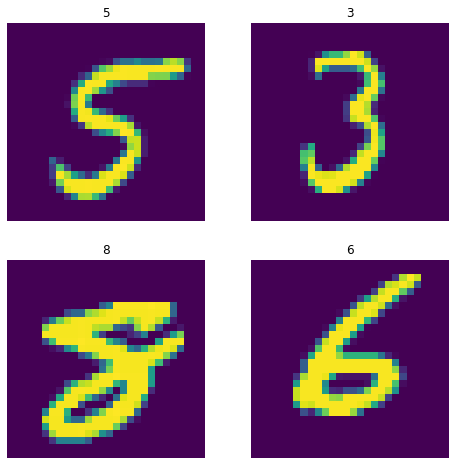

In [16]:
#-- Visualizamos los datos

fig = plt.figure(figsize=(8,8))
for i in range(4):
  plt.subplot(2,2,i+1)
  plt.imshow(X_test[i*15])
  plt.title(Y_test[i*15])
  plt.axis(False)
plt.show()

In [17]:
#--- Convetimos las listas con los datos a tensores de torch

X_train = Variable(torch.from_numpy(np.array(X_train))).float()
Y_train = Variable(torch.from_numpy(np.array(Y_train))).long()

X_valid = Variable(torch.from_numpy(np.array(X_valid))).float()
Y_valid = Variable(torch.from_numpy(np.array(Y_valid))).long()

X_test = Variable(torch.from_numpy(np.array(X_test))).float()
Y_test = Variable(torch.from_numpy(np.array(Y_test))).long()

X_train.data.size()

torch.Size([6000, 28, 28])

In [18]:
#-- Matriz de confusión

def CM(Y_true, Y_pred, classes):
  fig = plt.figure(figsize=(10, 10))
  cm = confusion_matrix(Y_true, Y_pred)
  lclasses = np.arange(0,classes)
  cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
  cmap=plt.cm.Blues
  ax = fig.add_subplot(1,1,1)
  im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
  ax.figure.colorbar(im, ax=ax, pad=0.01, shrink=0.86)
  ax.set(xticks=np.arange(cm.shape[1]), yticks=np.arange(cm.shape[0]),xticklabels=lclasses, yticklabels=lclasses)
  ax.set_xlabel("Predicted",size=20)
  ax.set_ylabel("True",size=20)
  ax.set_ylim(classes-0.5, -0.5)

  plt.setp(ax.get_xticklabels(), size=12)
  plt.setp(ax.get_yticklabels(), size=12)

  fmt = '.2f'
  thresh = cm.max()/2.
  for i in range(cm.shape[0]):
      for j in range(cm.shape[1]):
          ax.text(j, i, format(cm[i, j], fmt),ha="center", va="center",size=15 , color="white" if cm[i, j] > thresh else "black")

  plt.show()

#Metaparametros
* n_layers = Número de capas
* n_neurons = Número de neuronas
* n_epoch = Número de épocas
* lr = Tasa de aprendizaje - learning rate
* weight_decay = peso de decaímiento
* batch_size = Tamaño del subconjunto

In [30]:
#-- Entrenar y validar
def train_valid(model, n_epoch, optimizer, criterion):
  loss_train = []
  f1_train = []
  acc_train = []

  loss_valid = []
  f1_valid = []
  acc_valid = []

  for epoch in range(n_epoch):
    model.train()

    Xtr = X_train.view(X_train.size(0), -1)
    Y_pred = model(Xtr)

    loss = criterion(Y_pred,Y_train)
    loss_train.append(loss.item())

    Y_pred = torch.argmax(Y_pred, 1)
    f1_train.append( f1_score(Y_train,Y_pred, average='macro') )
    
    acc = sum(Y_train == Y_pred)/len(Y_pred)
    acc_train.append(acc)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    model.eval()
    Xvl = X_valid.view(X_valid.size(0), -1)
    Y_pred = model(Xvl)  
    loss = criterion(Y_pred,Y_valid)
    loss_valid.append(loss.item())

    Y_pred = torch.argmax(Y_pred, 1)
    f1_valid.append( f1_score(Y_valid, Y_pred, average='macro') )

    acc = sum(Y_valid == Y_pred)/len(Y_pred)
    acc_valid.append(acc)

  #print( 'Valid Evaluation loss: {}. f1:{} acc: {} '.format(loss_valid[-1], f1_valid[-1], acc_valid[-1]) )
  return (loss_valid[-1], f1_valid[-1], acc_valid[-1],Y_valid, Y_pred)
  #CM(Y_valid, Y_pred, 10)

# Descripción de los modelos:

##Modelo 1:

* Capas: 3
* Neuronas en las hidden_layers: 50

##Modelo 2:

* Capas: 2
* Neuronas en las hidden_layers: 100


#*En las dos celdas siguientes vamos a mostrar los mejores resultados con los scores obtenidos y la matriz de confusión para este caso.

  0%|          | 0/81 [00:00<?, ?it/s]

MAX valid Evaluation loss: 0.2973129451274872. f1:0.9127783872620231 acc: 0.9129999876022339, bs:512, lr:0.001, wd:0.1, ne:150 


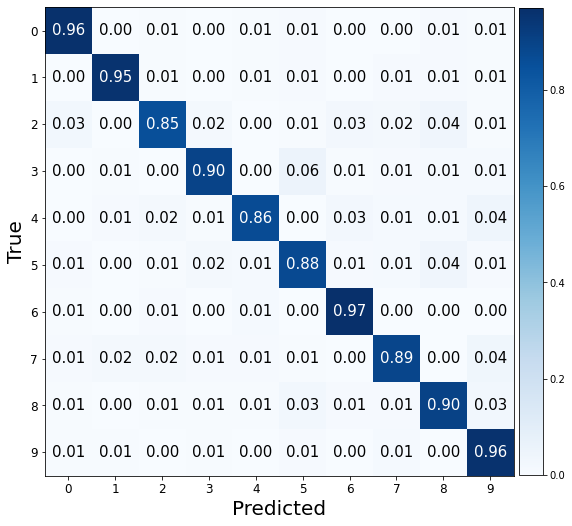

In [33]:
#-- Variamos los metaparametros para el modelo 1

bs_list = [256,512,1024]
lr_list = [0.001,0.01,0.1]
wd_list = [0.001,0.01,0.1]
ne_list = [50,100,150]

pbar = tqdm(total=len(bs_list)*len(lr_list)*len(wd_list)*len(ne_list))

max={}
max["loss"]=0
max['f1']=0
max['acc']=0
max['bs']=0
max['lr']=0
max['wd']=0
max['ne']=0

for ne in ne_list:
  for bs in bs_list:
    train_ds = TensorDataset(X_train, Y_train)
    train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True)

    for lr in lr_list:
      for wd in wd_list:
        input_dim = 28*28
        out_dim = 10
        hidden = 50

        model = torch.nn.Sequential(
          torch.nn.Linear(input_dim, hidden),
          torch.nn.ReLU(),
          torch.nn.Linear(hidden, hidden),
          torch.nn.ReLU(),
          torch.nn.Linear(hidden, out_dim)
        )

        optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=wd)
        criterion = torch.nn.CrossEntropyLoss()

        #print('ne: {}, wd:{}, lr: {}, bs:{} '.format(ne,wd,lr,bs))
        loss,f1,acc,Y_valid,Y_pred = train_valid(model,ne,optimizer,criterion)

        if (f1 > max['f1']):
          max["loss"] = loss
          max['f1'] = f1
          max['acc'] = acc
          max['bs'] = bs
          max['lr'] = lr
          max['wd'] = wd
          max['ne'] = ne
          max['Yvalid'] = Y_valid
          max['Ypred'] = Y_pred

        #print('###################\n')

        pbar.update()
pbar.close()

print( 'MAX valid Evaluation loss: {}. f1:{} acc: {}, bs:{}, lr:{}, wd:{}, ne:{} '.format(max["loss"] , max['f1'], max['acc'], max['bs'], max['lr'], max['wd'], max['ne']) )
CM(max['Yvalid'], max['Ypred'], 10)

  0%|          | 0/81 [00:00<?, ?it/s]

MAX valid Evaluation loss: 0.4214983284473419. f1:0.901040220626226 acc: 0.9010000228881836, bs:512, lr:0.001, wd:0.1, ne:150 


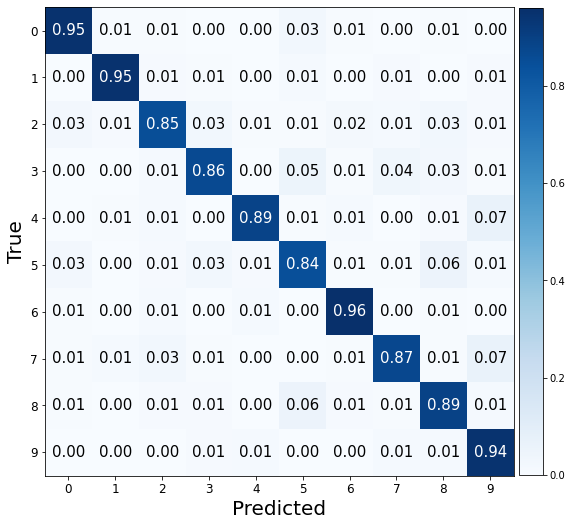

In [34]:
#-- Variamos los metaparametros para el modelo 2

bs_list = [256,512,1024]
lr_list = [0.001,0.01,0.1]
wd_list = [0.001,0.01,0.1]
ne_list = [50,100,150]

pbar = tqdm(total=len(bs_list)*len(lr_list)*len(wd_list)*len(ne_list))

max={}
max["loss"]=0
max['f1']=0
max['acc']=0
max['bs']=0
max['lr']=0
max['wd']=0
max['ne']=0

for ne in ne_list:
  for bs in bs_list:
    train_ds = TensorDataset(X_train, Y_train)
    train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True)

    for lr in lr_list:
      for wd in wd_list:
        input_dim = 28*28
        out_dim = 10
        hidden = 100

        model = torch.nn.Sequential(
          torch.nn.Linear(input_dim, hidden),
          torch.nn.ReLU(),
          torch.nn.Linear(hidden, out_dim)
        )

        optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=wd)
        criterion = torch.nn.CrossEntropyLoss()

        #print('ne: {}, wd:{}, lr: {}, bs:{} '.format(ne,wd,lr,bs))
        loss,f1,acc,Y_valid,Y_pred = train_valid(model,ne,optimizer,criterion)

        if (f1 > max['f1']):
          max["loss"] = loss
          max['f1'] = f1
          max['acc'] = acc
          max['bs'] = bs
          max['lr'] = lr
          max['wd'] = wd
          max['ne'] = ne
          max['Yvalid'] = Y_valid
          max['Ypred'] = Y_pred

        #print('###################\n')

        pbar.update()
pbar.close()

print( 'MAX valid Evaluation loss: {}. f1:{} acc: {}, bs:{}, lr:{}, wd:{}, ne:{} '.format(max["loss"] , max['f1'], max['acc'], max['bs'], max['lr'], max['wd'], max['ne']) )
CM(max['Yvalid'], max['Ypred'], 10)

#Análisis
*Se define el mejor resultado como el que tenga un mejor (mayor) valor para f1.

Entre ambos modelos, el que obtuvo mejores resultados fue el Modelo 1 pues tuvo un mejor f1 (f1:0.91 - modelo 1 vs f1:0.90 - modelo2)

Para el modelo 1, los mejores metaparámetros fueron **batch_size:512, learnind_rate:0.001, weight_decay:0.1, num_epocas:150** con un **f1: 0.912, loss: 0.297, acc: 0.912**. En este caso, el número que mejor se predijo fue el 6 y el peor fue el 2. La confusión más grande se presenta en un 6% de los "3" que se predicen como "5".

Para el modelo 2, los mejores metaparámetros fueron **batch_size:512, learnind_rate:0.001, weight_decay:0.1, num_epocas:150** con un **f1: **. en este caso, el número que mejor se predijo fue el 6 y el peor fue el 5. La confusión más grande se presenta en un 7% de los "4" y "7" que se predicen como "9".

**Ambos modelos tuvieron los mismos metaparametros para el mejor resultado.**
